<a href="https://colab.research.google.com/github/shraddha-an/nlp/blob/main/pretrained_glove_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case Study: NLP models for Text Classification**

## **Introduction**

In this project, I look at 2 different NLP models for classifying questions on Stack Overflow into 3 categories depending on their quality.

This Case Study outlines 2 techniques to achieve the task of text classification:

1.   [Training Word Embedding](https://github.com/shraddha-an/nlp/blob/main/word_embedding_classification.ipynb)
2.   Pretrained GloVe Word Embeddings

This Colab Notebook focusses on the second task, Using the GloVe pre-trained Embedding.


**Dataset**: [Stack Overflow Questions](https://www.kaggle.com/imoore/60k-stack-overflow-questions-with-quality-rate)


## 1) **Data Preparation**

In [ ]:
# Importing libraries
# Data Manipulation/ Handling
import pandas as pd, numpy as np

# Visualization
import seaborn as sb, matplotlib.pyplot as plt

# NLP libraries
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.utils import simple_preprocess

stop_words = set(stopwords.words('english'))

In [ ]:
# Importing training & testing datasets
dataset = pd.read_csv('train.csv')[['Body', 'Y']].rename(columns = {'Body': 'question', 'Y': 'category'})
ds = pd.read_csv('valid.csv')[['Body', 'Y']].rename(columns = {'Body': 'question', 'Y': 'category'})

## **2) NLP Preprocessing**

In [ ]:
# Removing symbols, stopwords, punctuation
symbols = re.compile(pattern = '[/<>(){}\[\]\|@,;]')
tags = ['href', 'http', 'https', 'www']

def text_clean(s: str) -> str:
    """
    Removes unwanted symbols, punctuation and stop words from a given string.
    """
    s = symbols.sub(' ', s)
    lemma = WordNetLemmatizer()
    for i in tags:
        s = s.replace(i, ' ')
    cleaned_text = ' '.join(lemma.lemmatize(word) for word in simple_preprocess(s, deacc = True) if not word in stop_words)
    return cleaned_text

# Applying the function on the questions column
dataset.iloc[:, 0] = dataset.iloc[:, 0].apply(text_clean)
ds.iloc[:, 0] = ds.iloc[:, 0].apply(text_clean)

# Train & Test subsets
X_train, y_train = dataset.iloc[:, 0].values, dataset.iloc[:, 1].values.reshape(-1, 1)
X_test, y_test = ds.iloc[:, 0].values, ds.iloc[:, 1].values.reshape(-1, 1)


## **3) Categorical Encoding**

In [ ]:
# One Hot Encoding the Categories Column
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(transformers = [('one_hot_encoder', ohe(categories = 'auto'), [0])],
                       remainder = 'passthrough')

y_train = ct.fit_transform(y_train)
y_test = ct.transform(y_test)

## **4) Tokenization**

In [ ]:
# Vectorizing our text corpus of questions
# Setting some paramters
vocab_size = 2100
glove_dim = 50
sequence_length = 300

# Tokenization with keras
from keras.preprocessing.text import Tokenizer

tk = Tokenizer(num_words = vocab_size)
tk.fit_on_texts(X_train)

X_train = tk.texts_to_sequences(X_train)
X_test = tk.texts_to_sequences(X_test)

# Padding all questions with zeros
from keras.preprocessing.sequence import pad_sequences

X_train_seq = pad_sequences(X_train, maxlen = 6700, padding = 'post')
X_test_seq = pad_sequences(X_test, maxlen = 6700, padding = 'post')


## 5) Building the Embedding Matrix

In [ ]:
# Importing the 50-dimensional embedding text file
path = 'Full path to your chosen dimensional glove text file'

embeddings = {}

with open(path, 'r', encoding = 'utf-8') as f:
    for line in f:
      values = line.split()                                          # Each line in the file is a word + 50 integers denoting its vector.
      embeddings[values[0]] = np.array(values[1:], 'float32')        # The first element of every line is a word & the rest 50 are its array of integers.


# Building the embeddings matrix out of words present in our corpus
embedding_matrix = np.zeros((vocab_size, glove_dim))            # glove_dim = 50 as I chose to use the 50-D embedding; replace it with the one you choose.

for word, index in word_index.items():
    if index < vocab_size:
        try:
          embedding_matrix[index] = embeddings[word]                  # If the embedding for the given word exists, retrieve it and map it to the word.
        except:
            pass



## **6) Embedding Model**


In [ ]:
# Buidling & Training the NN + Embedding layer
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten

model = Sequential()

model.add(Embedding(input_dim = vocab_size,
                    output_dim = glove_dim,
                    input_length = sequence))

model.add(Flatten())
model.add(Dense(units = 3, activation = 'softmax'))
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'categorical_crossentropy')

# Loading our pre-trained embedding matrix in the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False                       # Weights won't be updated while training.

# Training the model
history = model.fit(X_train_seq, y_train, epochs = 20, batch_size = 512, verbose = 1)

# Save the model
#model.save('model.h5')

## **6) Evaluating Performance**

In [ ]:
# Evaluating model performance on test set
loss, accuracy = model.evaluate(X_test_seq, y_test, verbose = 1)
print("\nAccuracy: {}\nLoss: {}".format(accuracy, loss))

Accuracy & Loss:

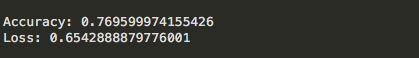